# Initialization

In [1]:
%matplotlib inline

In [2]:
import os
import glob

import numpy as np
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr

import ipywidgets as widgets
import xgcm

from numpy import pi as π

import sys

import ipywidgets as widgets
# sys.path.append('../analysis/')
# # m6toolbox is a python package that has a function that helps visualize vertical sections
# import m6toolbox

# sys.path.insert(0, '../pittwolfe')
import pittwolfe as pw
# from pittwolfe.util import sind, cosd

# latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
# lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)

In [3]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()

client = Client(cluster)
client

/Users/cwolfe/mambaforge/envs/py310/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61419 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:61420' processes=4 threads=16, memory=64.00 GiB>

# Specify the experiment

In [5]:
exclude_last_file = False

# expdir = '../2layer/flat/25km_newsponge'
# expdir = '../2layer/flat/25km'
# expdir = '../2layer/flat/25km_faster_sponge'
expdir = '../2layer/flat/25km_dt3600/F0.004-2.69-0.29_Ro0.23_b0.012'

# expdir = '../2layer/flat/5km_dt600'
# expdir = '../2layer/flat/5km_test'
# expdir = '../2layer/flat/5km_dt0540'

# Load data

In [6]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

In [7]:
g = 9.8

try:
    grid.close()
except:
    pass

grid = xr.open_dataset(os.path.join(expdir, 'static.nc'))
grid.close()

ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v})
ic.close()
grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

ρ0 = float(grid.zl.isel(zl=0))
grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

Lx = float(grid.dxT.isel(yh=0).sum('xh'))/1e3
Ly = float(grid.dyT.isel(xh=0).sum('yh'))/1e3

grid

<xarray.Dataset>
Dimensions:      (xh: 320, yh: 120, time: 1, xq: 321, yq: 121, zi: 3, zl: 2)
Coordinates:
  * xh           (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yh           (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * time         (time) object 0001-01-01 00:00:00
  * xq           (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq           (yq) float64 -1.5e+03 -1.475e+03 ... 1.475e+03 1.5e+03
    Time         timedelta64[ns] 36720 days
  * zi           (zi) float64 1.034e+03 1.036e+03 1.037e+03
  * zl           (zl) float64 1.035e+03 1.037e+03
Data variables: (12/19)
    area_t       (yh, xh) float32 ...
    area_u       (yh, xq) float32 ...
    area_v       (yq, xh) float32 ...
    area_q       (yq, xq) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    ...           ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dyCv         (yq, xh) float32 ...
    Idamp_u      (yh, xq) float32 ...
    Idamp_v      (yq, xh) float32 ...
    gprime       (zl) float64 9.8 0.01536
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [8]:
real_ic = xr.open_dataset(os.path.join(expdir, 'INPUT/jet_ic.nc'))
real_ic

<xarray.Dataset>
Dimensions:  (yh: 120, xh: 320, xq: 321, yq: 121, zl: 2, zi: 3)
Coordinates:
  * yh       (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * xh       (xh) float64 12.5 37.5 62.5 87.5 ... 7.938e+03 7.962e+03 7.988e+03
  * xq       (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq       (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    Kh       (yh, xh) float64 ...
    Idamp_u  (yh, xq) float64 ...
    Idamp_v  (yq, xh) float64 ...
    u        (zl, yh, xq) float64 ...
    v        (zl, yq, xh) float64 ...
    eta      (zi, yh, xh) float64 ...

In [9]:
grid_op = xgcm.Grid(grid, periodic=['X'], coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [10]:
try:
    snap.close()
except:
    pass

snap = xr.open_mfdataset(os.path.join(expdir, 'snapshot__????.nc'), decode_times=False, chunks={'time': 1})
# prog = xr.open_dataset(os.path.join(expdir, 'prog.nc'), decode_times=False)
snap

<xarray.Dataset>
Dimensions:  (xq: 321, yh: 120, zl: 2, time: 720, xh: 320, yq: 121, zi: 3)
Coordinates:
  * xq       (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yh       (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 717.0 718.0 719.0 720.0
  * xh       (xh) float64 12.5 37.5 62.5 87.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yq       (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03
Data variables:
    u        (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    v        (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    h        (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 120, 320), meta=np.ndarray>
    e        (time, zi, yh, xh) float32 dask.array<chunksize=(1, 3, 120, 320), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [11]:
try:
    prog.close()
except:
    pass

try:
    prog = xr.open_dataset(os.path.join(expdir, 'prog.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'prog__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
    
    prog = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})

prog

<xarray.Dataset>
Dimensions:     (xq: 321, yh: 120, zl: 2, time: 202, nv: 2, xh: 320, yq: 121,
                 zi: 3)
Coordinates:
  * xq          (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yh          (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl          (zl) float64 1.035e+03 1.037e+03
  * time        (time) float64 180.0 540.0 900.0 ... 7.218e+04 7.254e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yq          (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * zi          (zi) float64 1.034e+03 1.036e+03 1.037e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 120, 320), meta=np.ndarray>
    e           (time, zi, yh, xh) float32 dask.array<chunksize=(1, 3, 120, 320), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [12]:
try:
    mom.close()
except:
    pass

try:
    mom = xr.open_dataset(os.path.join(expdir, 'mom.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'mom__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
        
    mom = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})
mom

<xarray.Dataset>
Dimensions:        (xq: 321, yh: 120, zl: 2, time: 202, nv: 2, xh: 320, yq: 121)
Coordinates:
  * xq             (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yh             (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl             (zl) float64 1.035e+03 1.037e+03
  * time           (time) float64 180.0 540.0 900.0 ... 7.218e+04 7.254e+04
  * nv             (nv) float64 1.0 2.0
  * xh             (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yq             (yq) float64 -1.5e+03 -1.475e+03 ... 1.475e+03 1.5e+03
Data variables:
    u_ref          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    v_ref          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    u_tend_sponge  (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    v_tend_sponge  (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    average_T1     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds      (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [13]:
try:
    visc.close()
except:
    pass

try:
    visc = xr.open_dataset(os.path.join(expdir, 'visc.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'visc__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
        
    visc = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})

visc

<xarray.Dataset>
Dimensions:     (xh: 320, yh: 120, zl: 2, time: 202, nv: 2, xq: 321, yq: 121)
Coordinates:
  * xh          (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yh          (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl          (zl) float64 1.035e+03 1.037e+03
  * time        (time) float64 180.0 540.0 900.0 ... 7.218e+04 7.254e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq          (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
Data variables:
    Ahh         (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 120, 320), meta=np.ndarray>
    Ahq         (time, zl, yq, xq) float32 dask.array<chunksize=(1, 2, 121, 321), meta=np.ndarray>
    Khh         (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 120, 320), meta=np.ndarray>
    Khq         (time, zl, yq, xq) float32 dask.array<chunksize=(1, 2, 121, 321), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [14]:
try:
    stats.close()
except:
    pass
stats = xr.open_dataset(os.path.join(expdir, 'OUTPUT/ocean.stats.nc'), decode_times=False)
t_end = int(stats.Time[-1])
stats.close()

Nl = len(stats.Layer)
stats

<xarray.Dataset>
Dimensions:        (Layer: 2, Interface: 3, Time: 72723)
Coordinates:
  * Layer          (Layer) float64 1.035e+03 1.037e+03
  * Interface      (Interface) float64 1.034e+03 1.036e+03 1.037e+03
  * Time           (Time) float64 0.0 1.0 2.0 ... 7.272e+04 7.272e+04 7.272e+04
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  OUTPUT/ocean.stats.nc

# Spinup stats

TypeError: Figure.savefig() takes 2 positional arguments but 3 were given

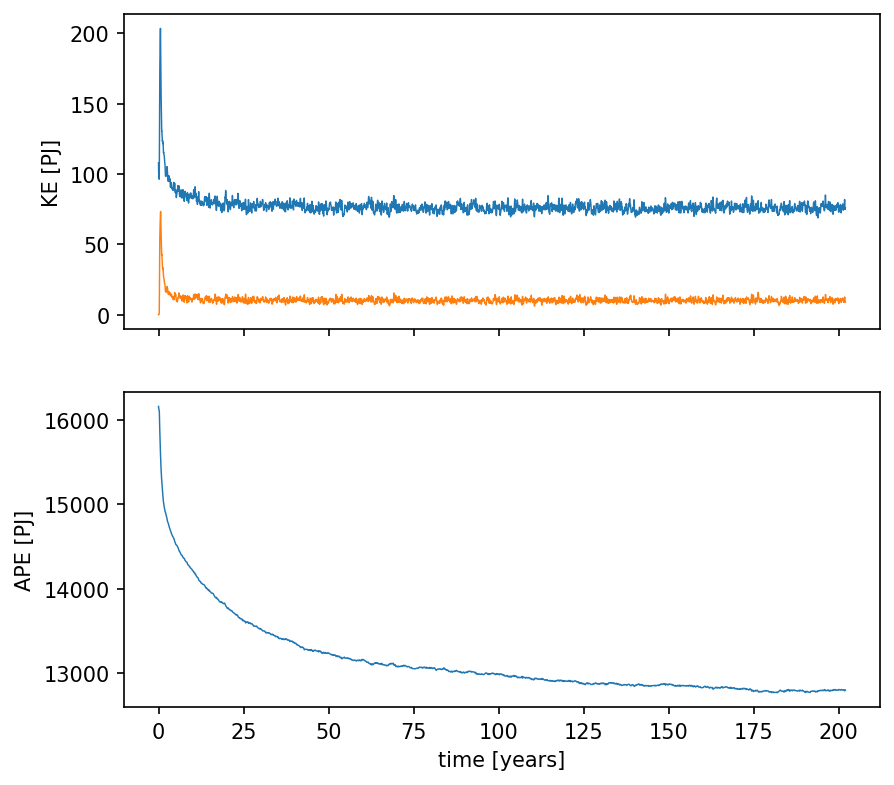

In [17]:
years = stats.Time/360

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5, 6))

ax = axs[0]
for zl in range(Nl):
    ax.plot(years, stats.KE.isel(Layer=zl)/1e15, label='layer ' + str(zl+1), lw=.7)
# ax.legend()
ax.set_ylabel('KE [PJ]')

ax = axs[1]
for zi in range(1,Nl):
    ax.plot(years, stats.APE.isel(Interface=zi)/1e15, label='interface ' + str(zi), lw=.7)
# ax.legend()
ax.set_ylabel('APE [PJ]')
ax.set_xlabel('time [years]')

fig.savefig(fig, 'energy')

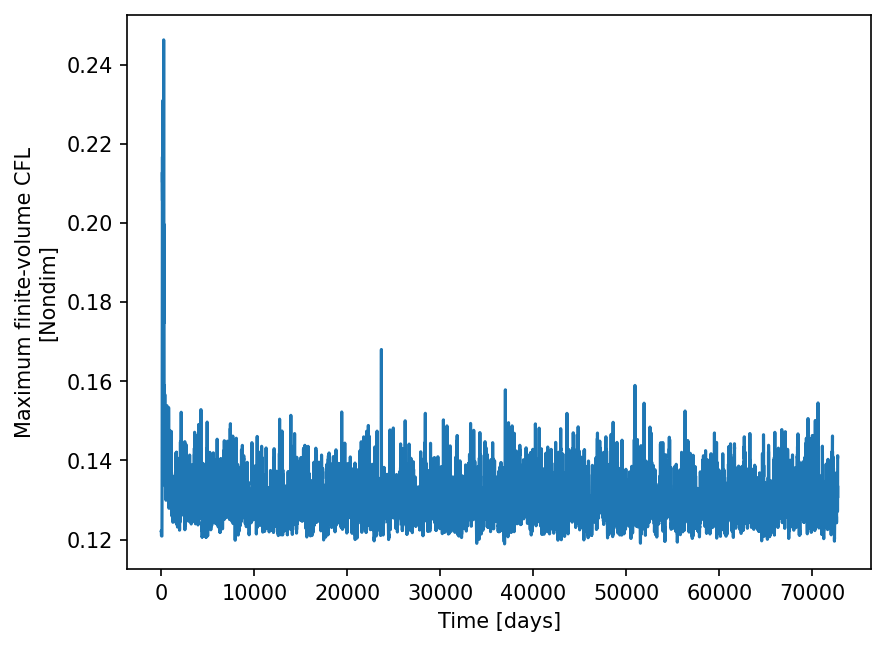

In [18]:
stats.max_CFL_trans.plot()

# Snapshots

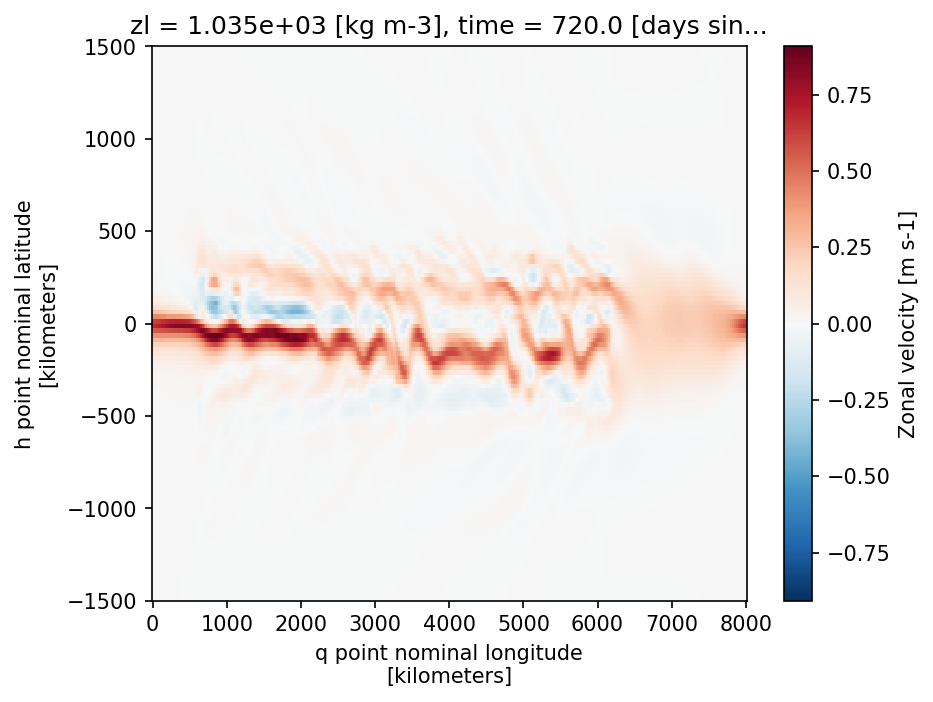

In [19]:
snap.u.isel(zl=0,time=-1).plot()
# plt.gca().set_aspect(1)

## Figure out if the relaxation is working

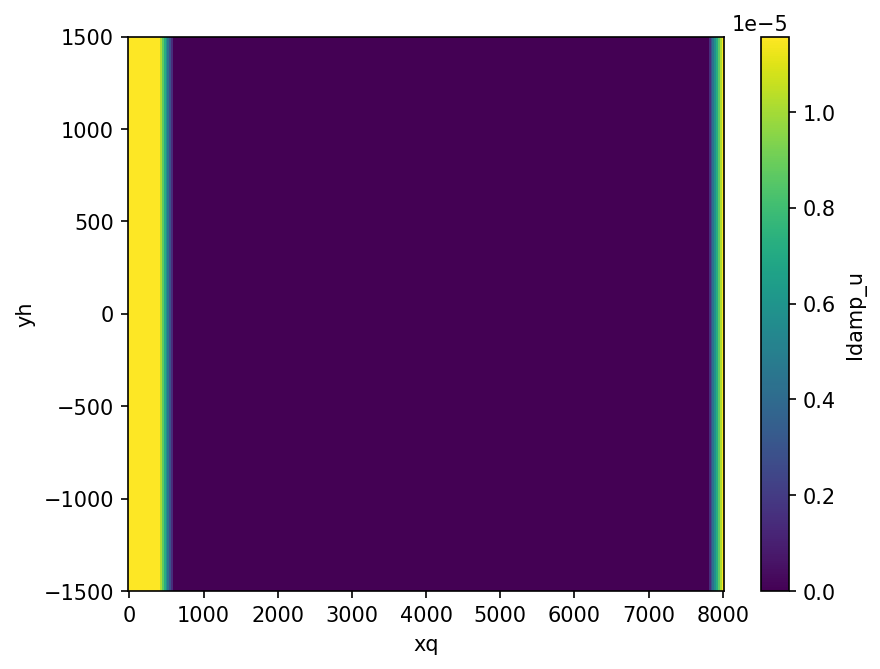

In [20]:
real_ic.Idamp_u.plot()

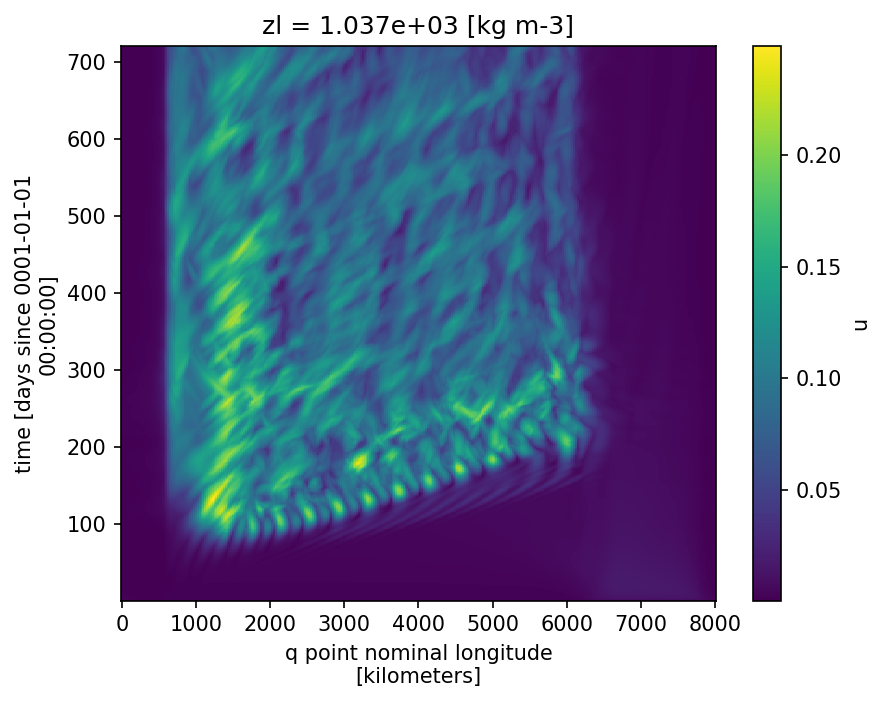

In [21]:
np.abs(snap.u.isel(zl=1)).max('yh').plot()

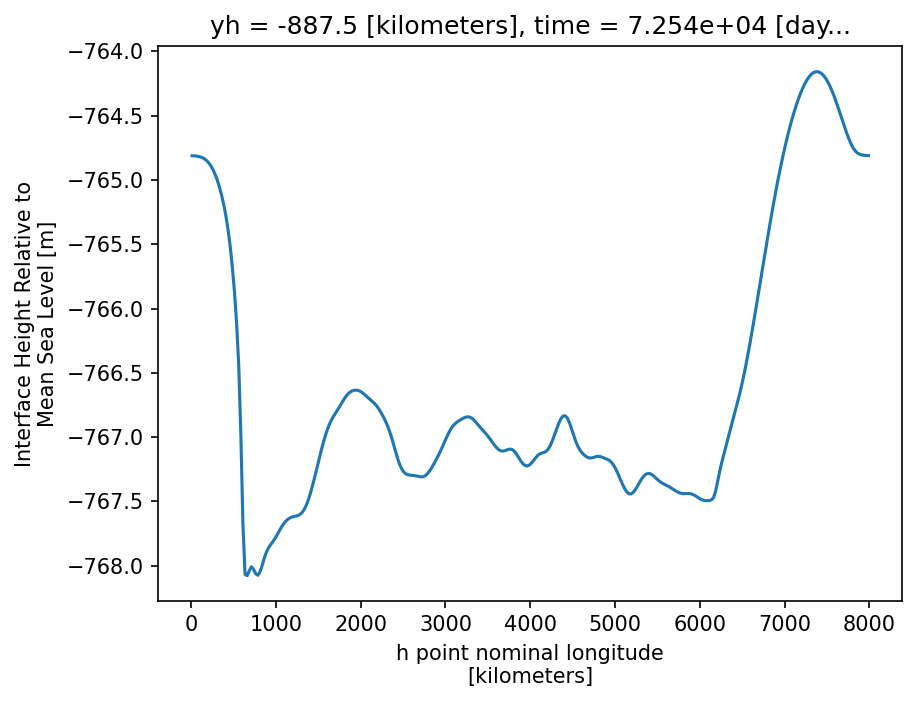

In [22]:
prog.e.isel(zi=1, time=-1).sel(yh=-900, method='nearest').plot()

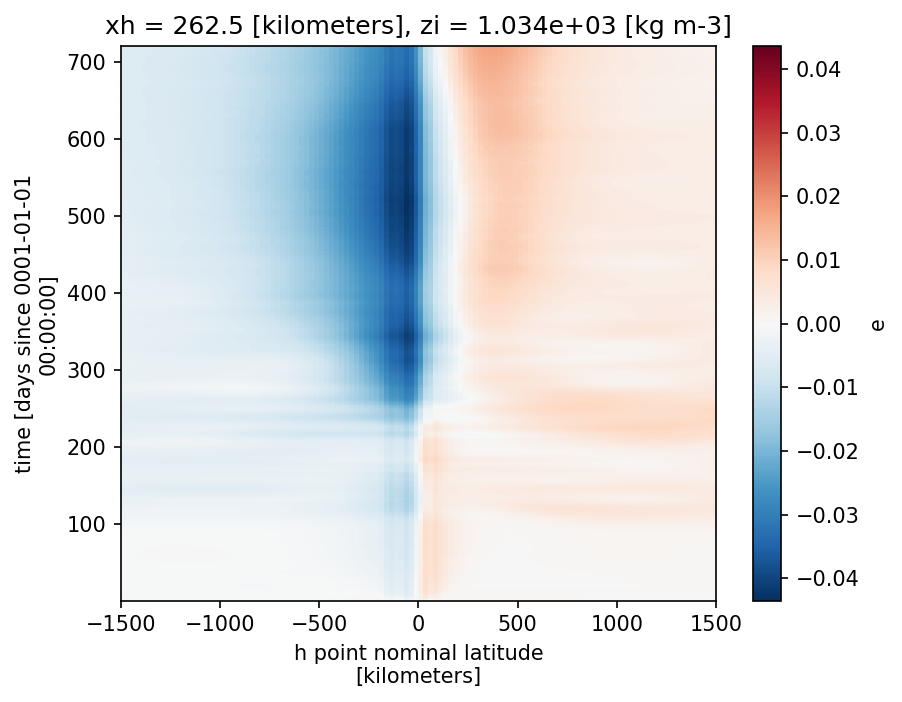

In [23]:
(snap.e.isel(zi=0) - snap.e.isel(zi=0,time=0)).sel(xh=250, method='nearest').plot()

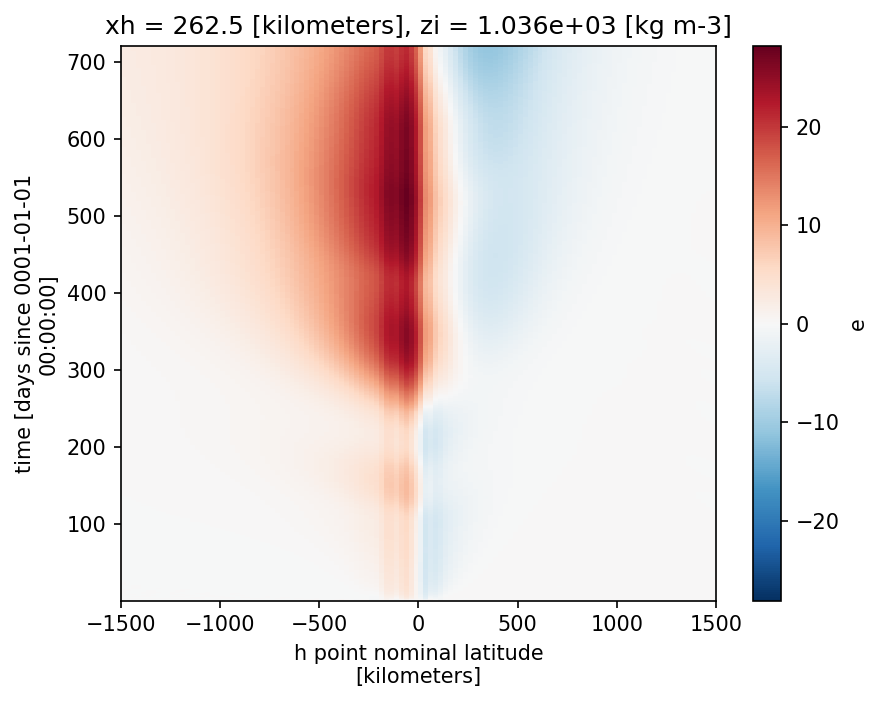

In [25]:
(snap.e.isel(zi=1) - snap.e.isel(zi=1,time=0)).sel(xh=250, method='nearest').plot()

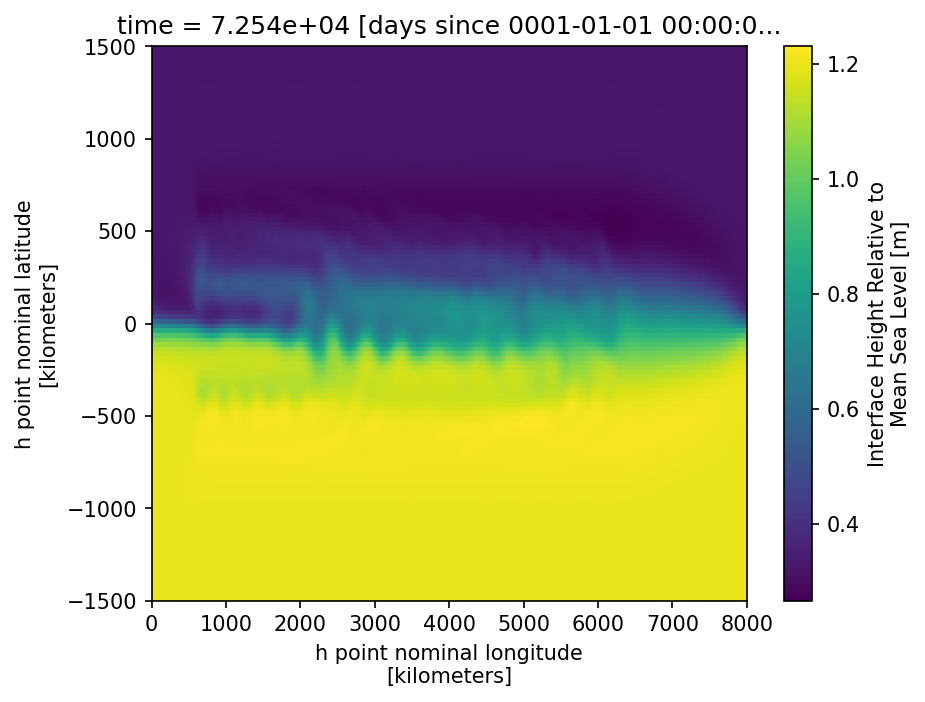

In [24]:
prog.e.isel(zi=0,time=-1).plot()

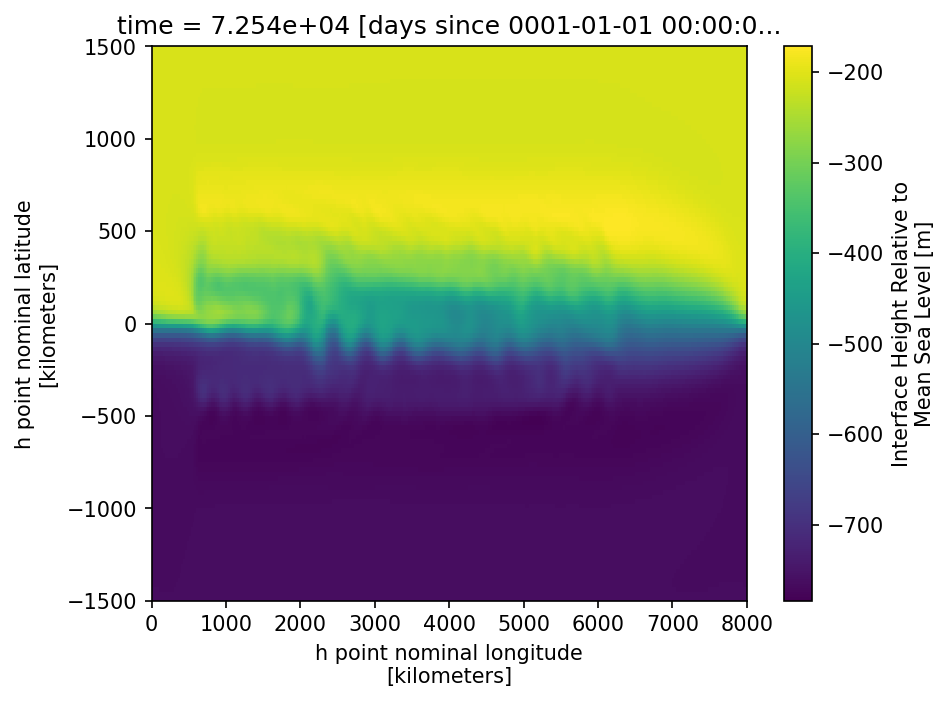

In [25]:
prog.e.isel(zi=1,time=-1).plot()

# Means

In [26]:
time_mean = slice(-10, None)

In [27]:
ubar = prog.u.isel(time=time_mean).mean('time').load()
vbar = prog.v.isel(time=time_mean).mean('time').load()
ηbar = prog.e.isel(time=time_mean).mean('time').load()

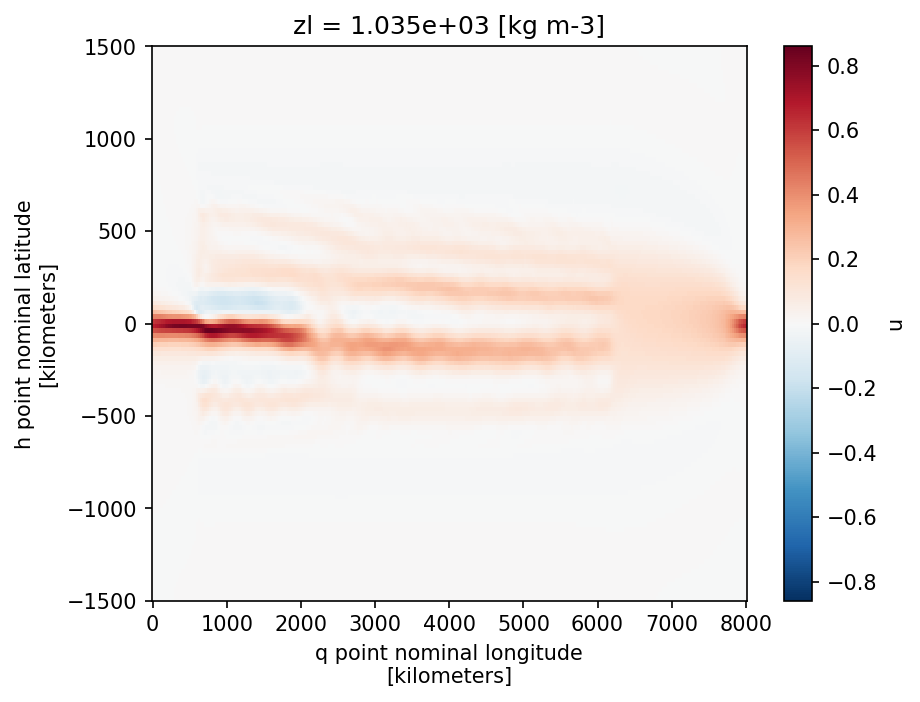

In [69]:
ubar.isel(zl=0).plot()

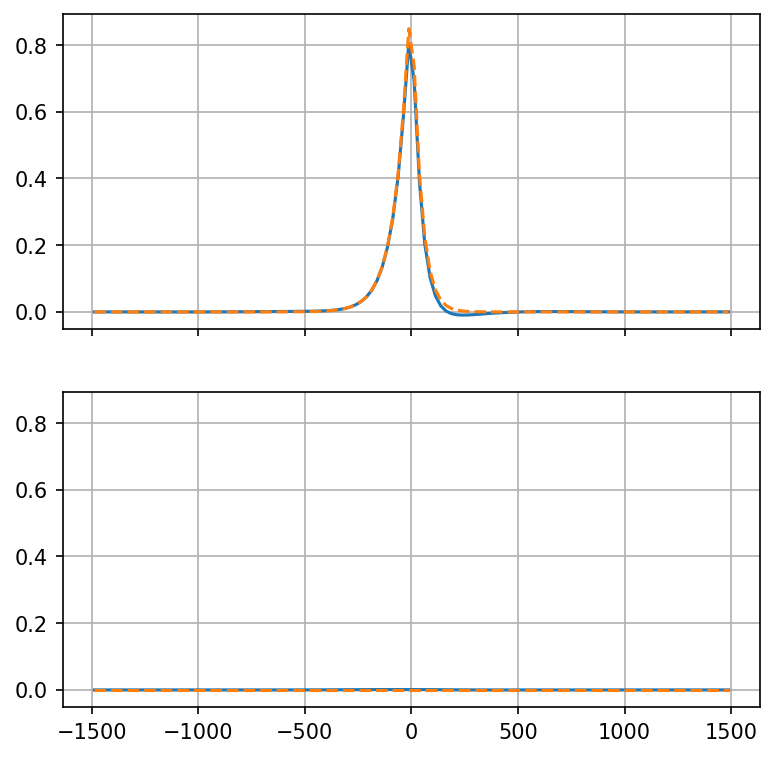

In [28]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 6))

X = 250

for zl in range(2):
    axs[zl].plot(grid.yh, ubar.isel(zl=zl).sel(xq=X, method='nearest'))
    axs[zl].plot(grid.yh, real_ic.u.isel(zl=zl).sel(xq=X, method='nearest'), '--')
    axs[zl].grid()
    
fig.savefig(os.path.join(expdir, 'usponge.pdf'), bbox_inches='tight')

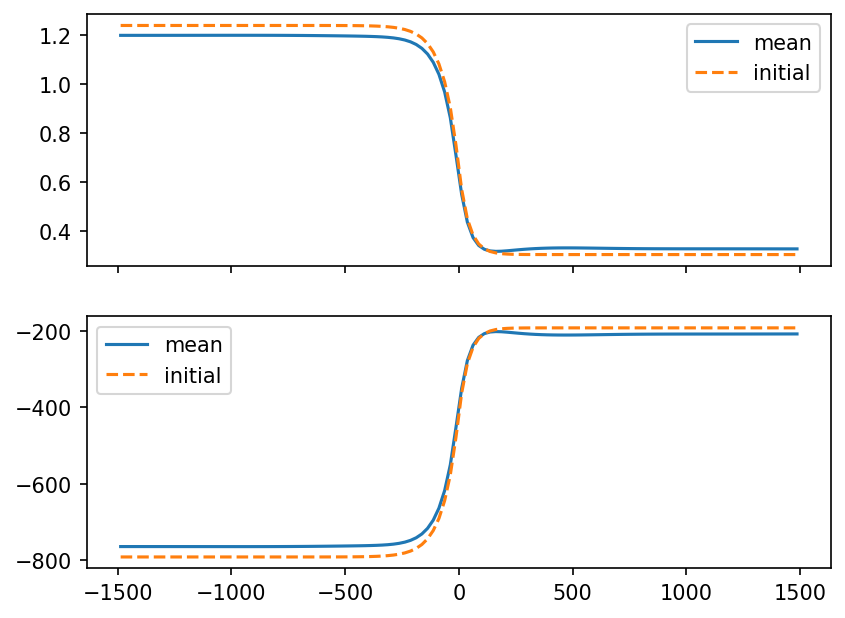

In [30]:
fig, axs = plt.subplots(nrows=2, sharex=True)

for k in range(2):
    ax = axs[k]
    ax.plot(grid.yh, ηbar.isel(zi=k).sel(xh=X, method='nearest'), label='mean')
    ax.plot(grid.yh, real_ic.eta.isel(zi=k).sel(xh=X, method='nearest'), '--', label='initial')
    # ax.set_xlim(-300, 300)
    ax.legend()

fig.savefig(os.path.join(expdir, 'etasponge.pdf'), bbox_inches='tight')

In [33]:
ηx = grid_op.diff(ηbar, 'X')/grid.dxCu
ηy = grid_op.diff(ηbar, 'Y')/grid.dyCv*grid.wet_v

pgfu0 = -g*ηx.isel(zi=0)
pgfu1 = -g*ηx.isel(zi=0) - grid.gprime.isel(zl=1)*ηx.isel(zi=1)
pgfv0 = -g*ηy.isel(zi=0)
pgfv1 = -g*ηy.isel(zi=0) - grid.gprime.isel(zl=1)*ηy.isel(zi=1)


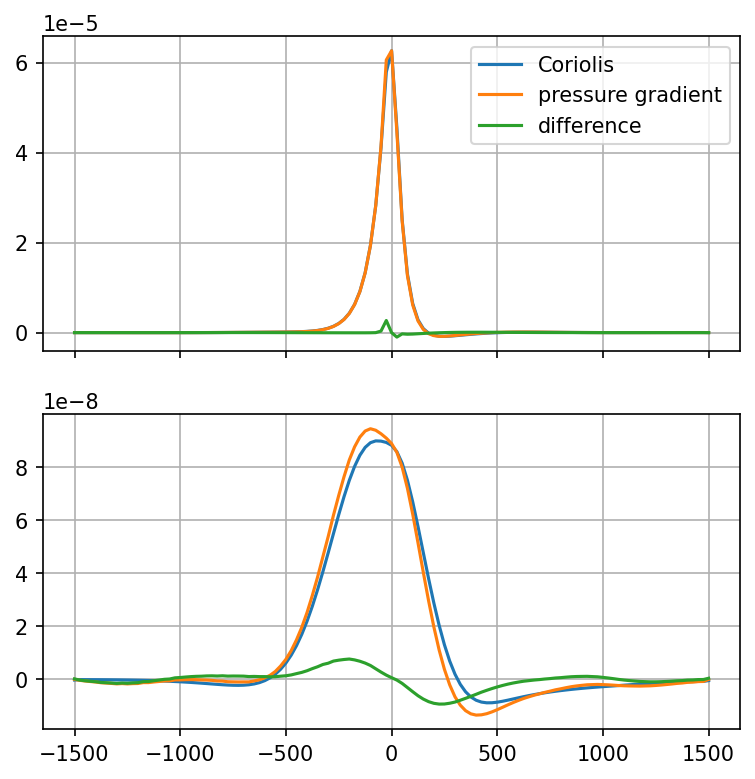

In [49]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(6, 6))

X = 250
fu = grid_op.interp(grid.fq.isel(xq=0), 'Y')

ax = axs[0]
ax.plot(grid.yq, (grid.fq*grid_op.interp(ubar.isel(zl=0), 'Y')).sel(xq=X, method='nearest'), label='Coriolis')
ax.plot(grid.yq, pgfv0.sel(xh=X, method='nearest'), label='pressure gradient')
ax.plot(grid.yq, pgfv0.sel(xh=X, method='nearest') 
        - (grid.fq*grid_op.interp(ubar.isel(zl=0), 'Y')).sel(xq=X, method='nearest'), label='difference')
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(grid.yq, (grid.fq*grid_op.interp(ubar.isel(zl=1), 'Y')).sel(xq=X, method='nearest'), label='Coriolis')
ax.plot(grid.yq, pgfv1.sel(xh=X, method='nearest'), label='pressure gradient')
ax.plot(grid.yq, pgfv1.sel(xh=X, method='nearest') 
        - (grid.fq*grid_op.interp(ubar.isel(zl=1), 'Y')).sel(xq=X, method='nearest'), label='difference')
ax.grid()


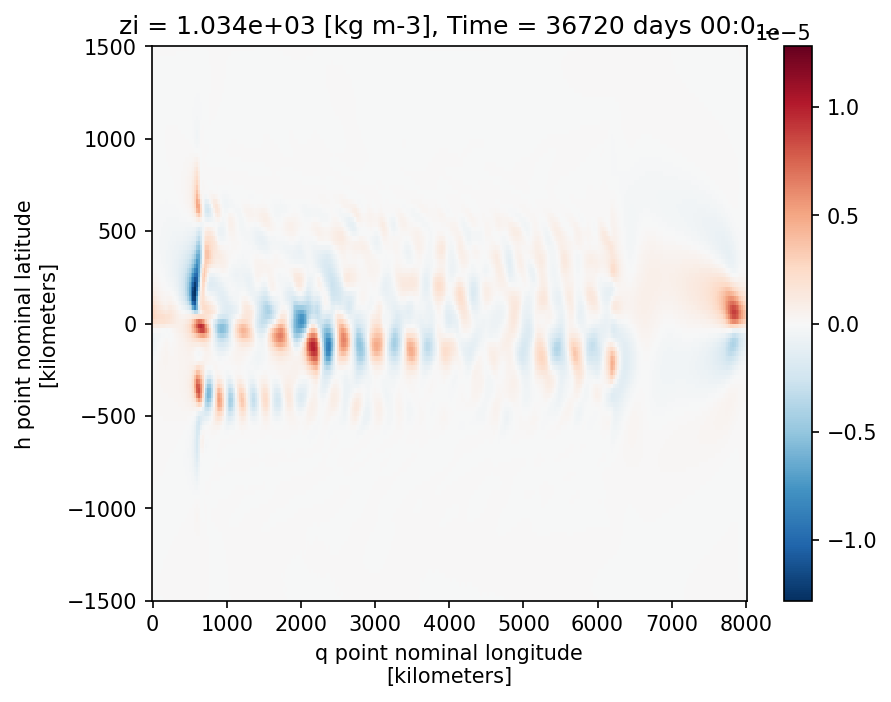

In [34]:
pgfu0.plot()

## Continuity

In [31]:
uh = prog.uh.isel(time=time_mean).mean('time').load()
vh = prog.vh.isel(time=time_mean).mean('time').load()

uhx = grid_op.diff(uh, 'X')/grid.area_t
vhy = grid_op.diff(vh, 'Y')/grid.area_t


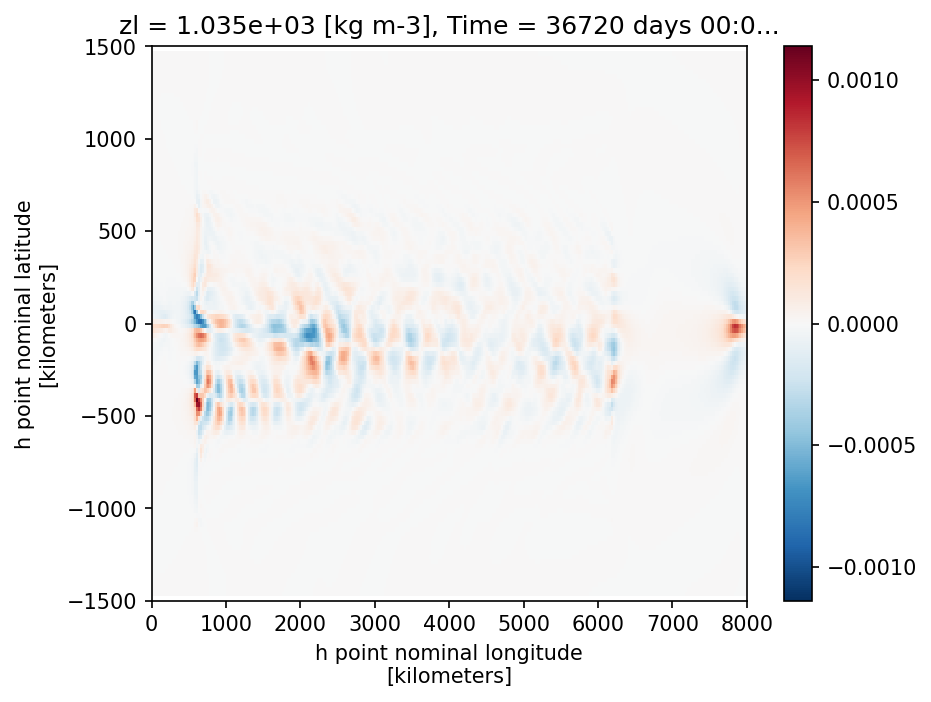

In [32]:
(uhx + 0*vhy).isel(zl=0).plot()
# plt.xlim(200, 500)

## Barotropic streamfunction

In [50]:
U = prog.uh.isel(time=time_mean).mean('time').sum('zl').load()
psiB = -1e-6*grid_op.cumsum(U, 'Y', boundary='fill', fill_value=0)
psiB = psiB - psiB.isel(yq=-1).mean()/2

In [51]:
recirc_pos_south = psiB.argmax(dim=('xq', 'yq'))
recirc_pos_north = psiB.argmin(dim=('xq', 'yq'))

recirc_x_south = float(psiB.xq.isel(xq=int(recirc_pos_south['xq'])))
recirc_x_north = float(psiB.xq.isel(xq=int(recirc_pos_north['xq'])))

recirc_x = (recirc_x_south + recirc_x_north)/2

recirc_y_south = float(psiB.yq.isel(yq=int(recirc_pos_south['yq'])))
recirc_y_north = float(psiB.yq.isel(yq=int(recirc_pos_north['yq'])))

In [52]:
psiB_N = psiB.isel(yq= 0).mean('xq')
psiB_S = psiB.isel(yq=-1).mean('xq')

recirc_north = float(psiB_S - psiB.min())
recirc_south = float(psiB.max() - psiB_N)

In [53]:
np.abs(psiB).max()

<xarray.DataArray 'uh' ()>
array(63.51605225)

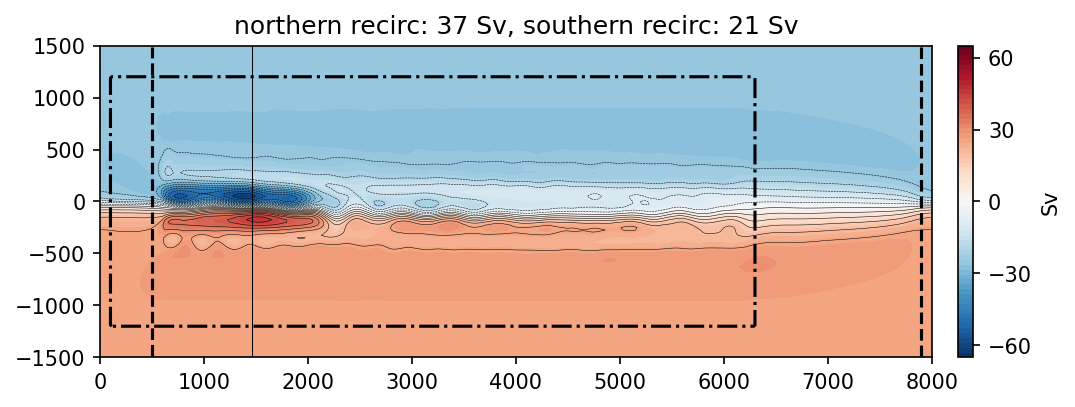

In [54]:
fig, ax = plt.subplots(figsize=(9, 2.7))

vmax = 65
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(psiB.xq, psiB.yq, psiB, levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ticks=np.arange(-120, 120+1, 30), label='Sv', pad=0.025)
ax.contour(psiB.xq, psiB.yq, psiB, levels=np.arange(-120, 120+1, 5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

ax.axvline(recirc_x, color='k', lw=.5)

ax.set_title('northern recirc: {:.0f} Sv, southern recirc: {:.0f} Sv'.format(recirc_north, recirc_south))

fig.savefig(os.path.join(expdir,'streamfunction.pdf'), bbox_inches='tight')

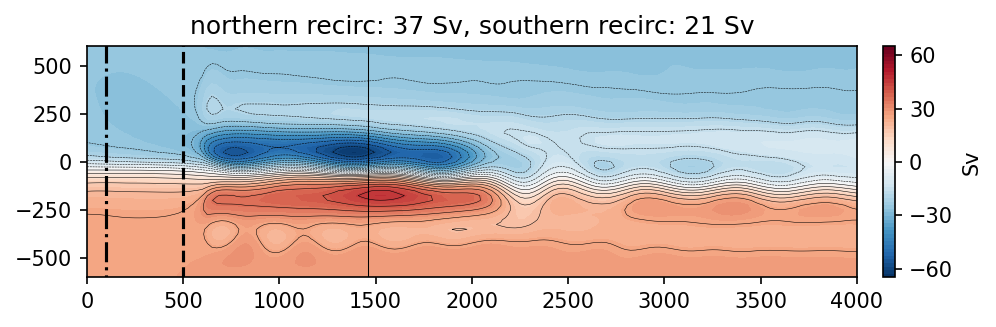

In [55]:
fig, ax = plt.subplots(figsize=(9, 2))

vmax = 65
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(psiB.xq, psiB.yq, psiB, levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ticks=np.arange(-120, 120+1, 30), label='Sv', pad=0.025)
ax.contour(psiB.xq, psiB.yq, psiB, levels=np.arange(-120, 120+1, 5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax.set_title('northern recirc: {:.0f} Sv, southern recirc: {:.0f} Sv'.format(recirc_north, recirc_south))

fig.savefig(os.path.join(expdir,'streamfunction_zoom.pdf'), bbox_inches='tight')

### Per layer

In [56]:
U = prog.uh.isel(time=time_mean).mean('time').load()
psi = -1e-6*grid_op.cumsum(U, 'Y', boundary='fill', fill_value=0)
psi = psi - psi.isel(yq=-1).mean('xq')/2

In [57]:
np.abs(psi).max()

<xarray.DataArray 'uh' ()>
array(38.811478, dtype=float32)

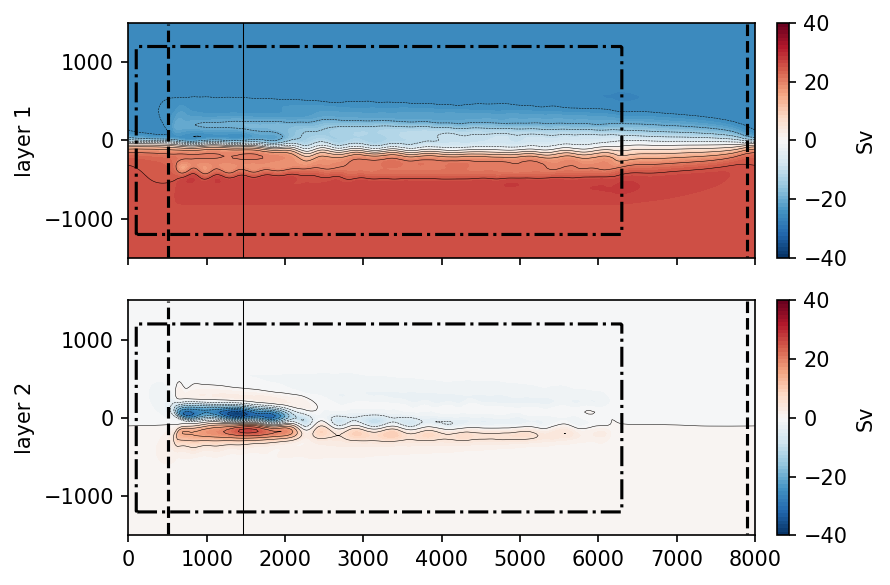

In [58]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6.5, 4))

vmax = 40
vmin = -vmax
levels = np.linspace(vmin, vmax, 65)

for zl in range(2):
    ax = axs[zl]
    
    cs = ax.contourf(psi.xq, psi.yq, psi.isel(zl=zl), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.contour(psi.xq, psi.yq, psi.isel(zl=zl), levels=np.arange(-120, 120+1, 5), colors='k', linewidths=.25)
    ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
    ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
    
    ax.set_aspect(1)
    ax.axvline(recirc_x, color='k', lw=.5)
    fig.colorbar(cs, ax=ax, ticks=np.arange(-40, 41, 20), pad=.025, label='Sv')
    ax.set_ylabel('layer {:d}'.format(zl+1))
    
fig.tight_layout()
fig.savefig(os.path.join(expdir,'streamfunction_by_layer.pdf'), bbox_inches='tight')

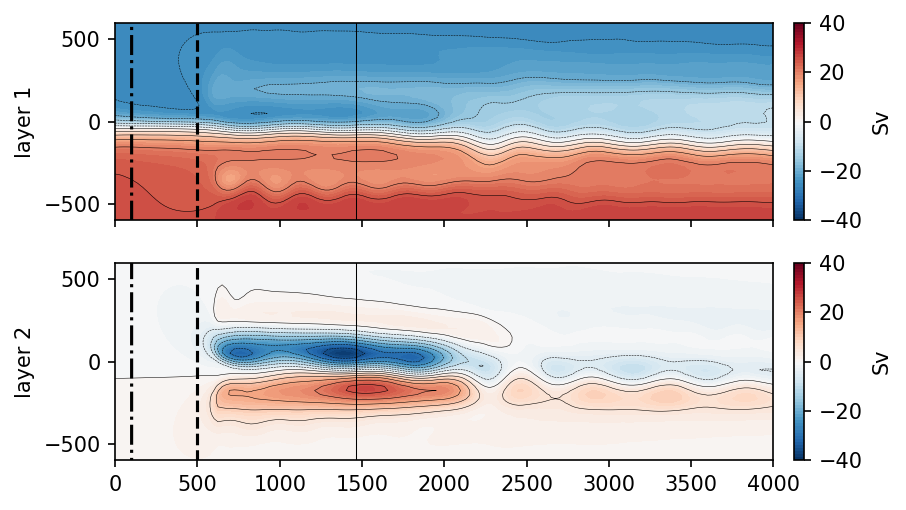

In [59]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6.5, 3.5))

vmax = 40
vmin = -vmax
levels = np.linspace(vmin, vmax, 65)

for zl in range(2):
    ax = axs[zl]
    
    cs = ax.contourf(psi.xq, psi.yq, psi.isel(zl=zl), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.contour(psi.xq, psi.yq, psi.isel(zl=zl), levels=np.arange(-120, 120+1, 5), colors='k', linewidths=.25)
    ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
    ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
    
    ax.set_aspect(1)
    ax.axvline(recirc_x, color='k', lw=.5)
    fig.colorbar(cs, ax=ax, ticks=np.arange(-40, 41, 20), pad=.025, label='Sv')
    ax.set_ylabel('layer {:d}'.format(zl+1))
    
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)
fig.tight_layout()
fig.savefig(os.path.join(expdir,'streamfunction_by_layer_zoom.pdf'), bbox_inches='tight')

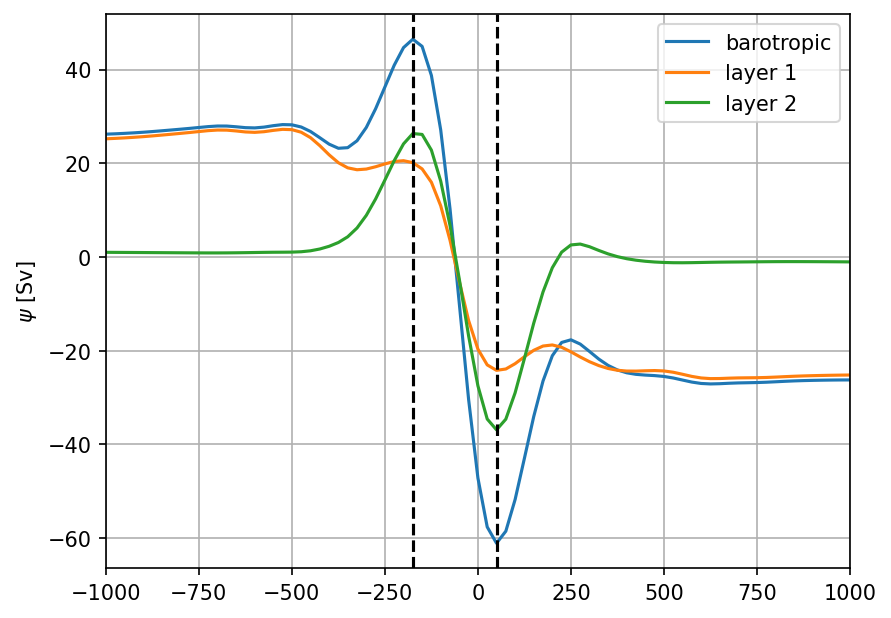

In [114]:
fig, ax = plt.subplots()

ax.plot(psiB.yq, psiB.sel(xq=recirc_x, method='nearest'), label='barotropic')
ax.plot(psi.yq, psi.isel(zl=0).sel(xq=recirc_x, method='nearest'), label='layer 1')
ax.plot(psi.yq, psi.isel(zl=1).sel(xq=recirc_x, method='nearest'), label='layer 2')
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_xlim([-1000, 1000])
ax.set_ylabel('$\psi$ [Sv]')
ax.legend()

fig.savefig(os.path.join(expdir,'streamfunction_recirc_profile.pdf'), bbox_inches='tight')

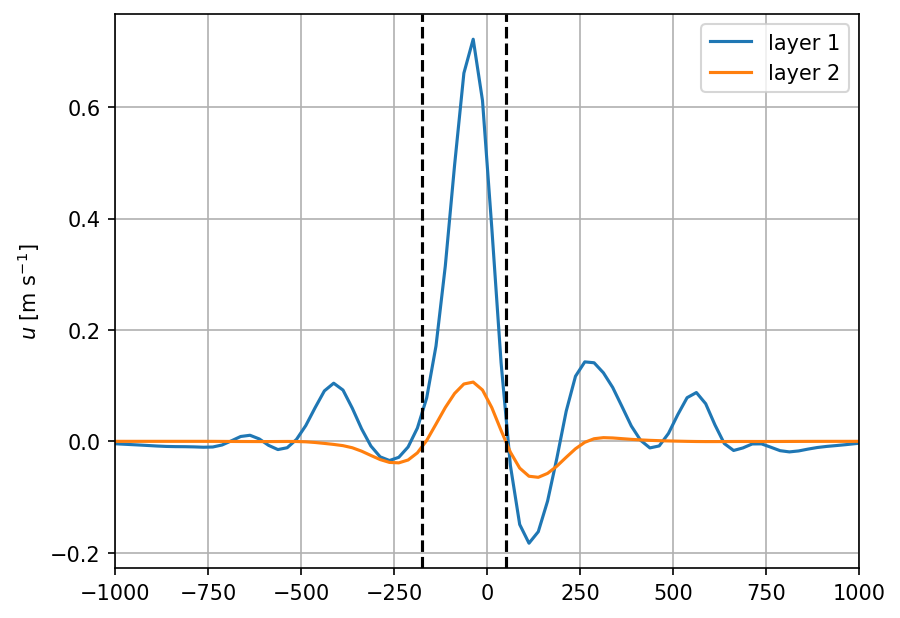

In [113]:
fig, ax = plt.subplots()

ax.plot(grid.yh, ubar.isel(zl=0).sel(xq=recirc_x, method='nearest'), label='layer 1')
ax.plot(grid.yh, ubar.isel(zl=1).sel(xq=recirc_x, method='nearest'), label='layer 2')
ax.set_xlim([-1000, 1000])
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.legend()
ax.set_ylabel('$u$ [m s$^{-1}$]')

fig.savefig(os.path.join(expdir,'uvel_recirc_profile.pdf'), bbox_inches='tight')

## Interfaces

In [74]:
ηbar = prog.e.isel(zi=slice(None, 2), time=time_mean).mean('time')

In [75]:
np.abs(ηbar).max(('xh', 'yh')).values

array([  1.2240179, 779.9505   ], dtype=float32)

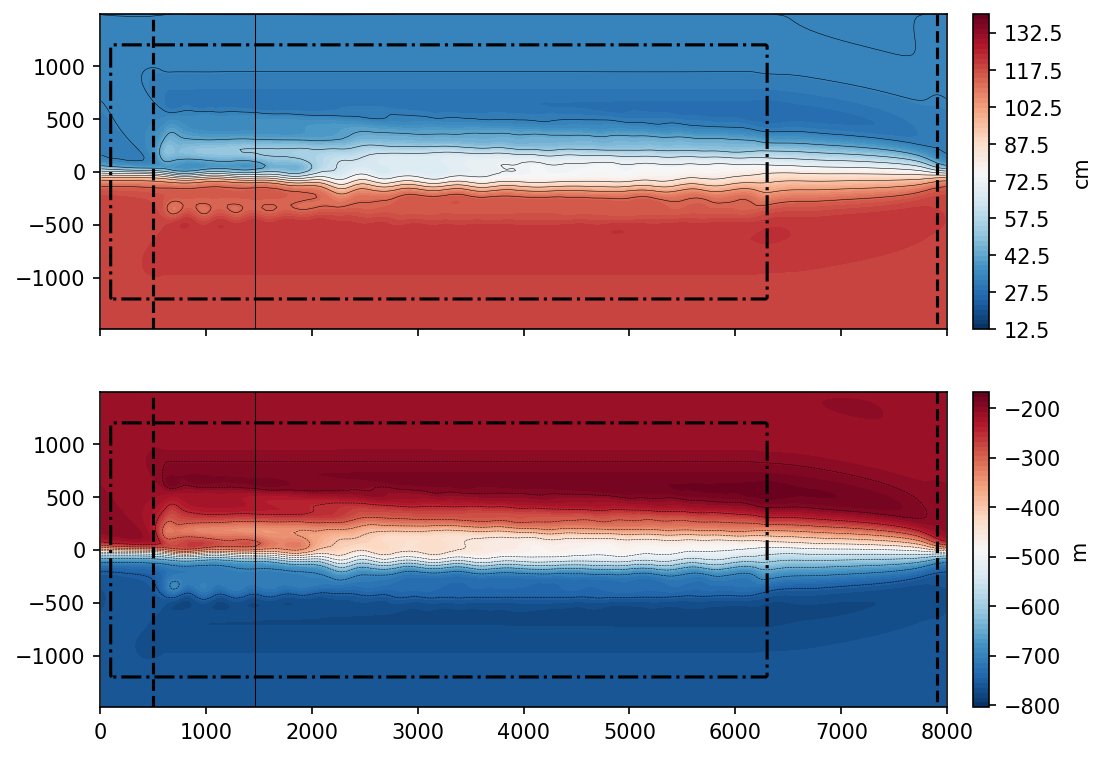

In [76]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmin = float(100*ηbar.isel(zi=0, yh=-1).mean().values) - 20
vmax = float(100*ηbar.isel(zi=0, yh= 1).mean().values) + 20
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(vmin, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 40
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-800, -180+1, 50), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'eta.pdf'), bbox_inches='tight')

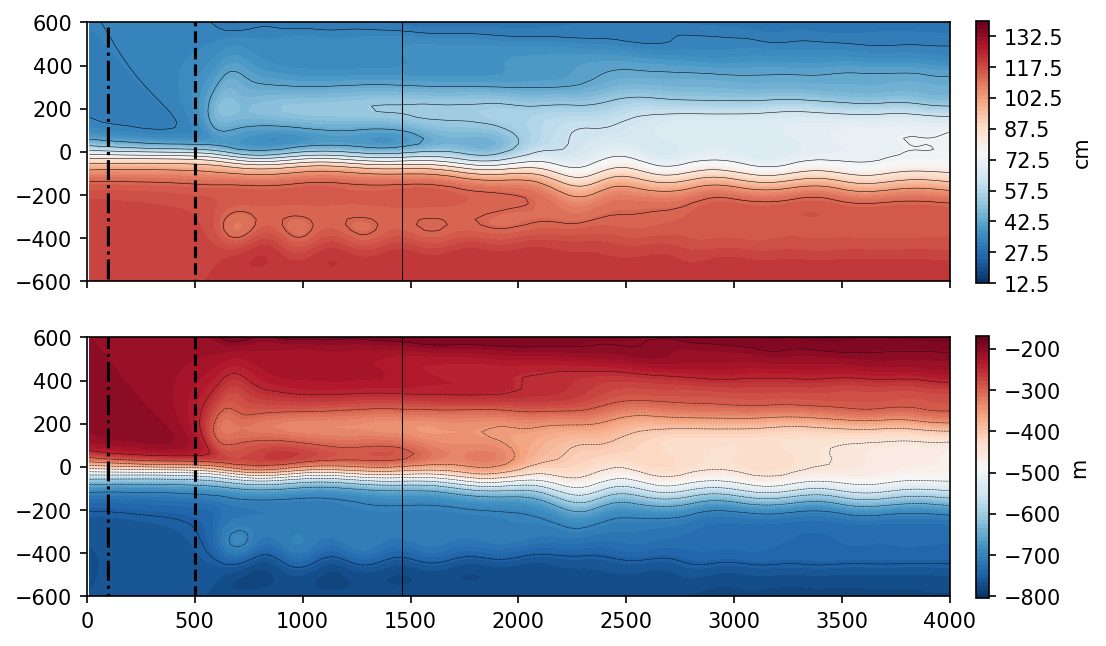

In [77]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmin = float(100*ηbar.isel(zi=0, yh=-1).mean().values) - 20
vmax = float(100*ηbar.isel(zi=0, yh= 1).mean().values) + 20
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(vmin, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 40
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-800, -180+1, 50), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'eta_zoom.pdf'), bbox_inches='tight')

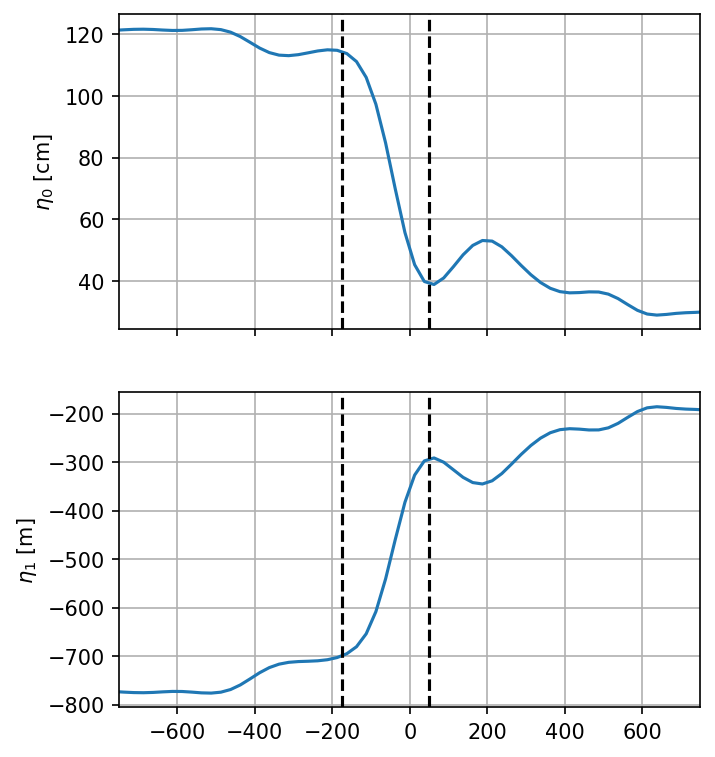

In [112]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

ax = axs[0]
ax.plot(ηbar.yh, 100*ηbar.isel(zi=0).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_0$ [cm]')

ax = axs[1]
ax.plot(ηbar.yh, ηbar.isel(zi=1).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_1$ [m]')

ax.set_xlim([-750, 750])
fig.savefig(os.path.join(expdir,'eta_profile.pdf'), bbox_inches='tight')

## Thicknesses

In [79]:
hbar = prog.h.isel(time=time_mean).mean('time')

In [80]:
np.abs(hbar).max(('xh', 'yh')).values

array([ 781.17456, 4827.1953 ], dtype=float32)

In [81]:
hbar.isel(zl=0, yh=-1).mean().values

array(208.80867, dtype=float32)

In [82]:
hbar.isel(zl=0, yh= 1).mean().values

array(765.5575, dtype=float32)

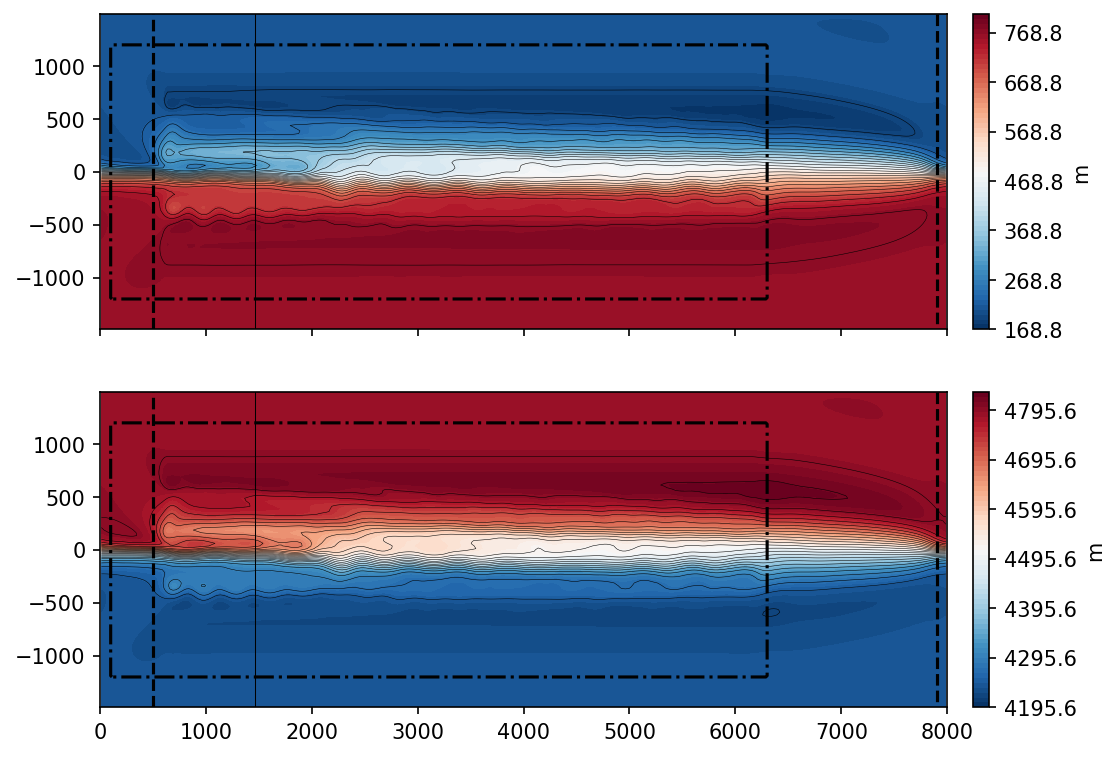

In [83]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmin = float(hbar.isel(zl=0, yh=-1).mean().values) - 40
vmax = float(hbar.isel(zl=0, yh= 1).mean().values) + 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmax = float(hbar.isel(zl=1, yh=-1).mean().values) + 40
vmin = float(hbar.isel(zl=1, yh= 1).mean().values) - 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'h.pdf'), bbox_inches='tight')

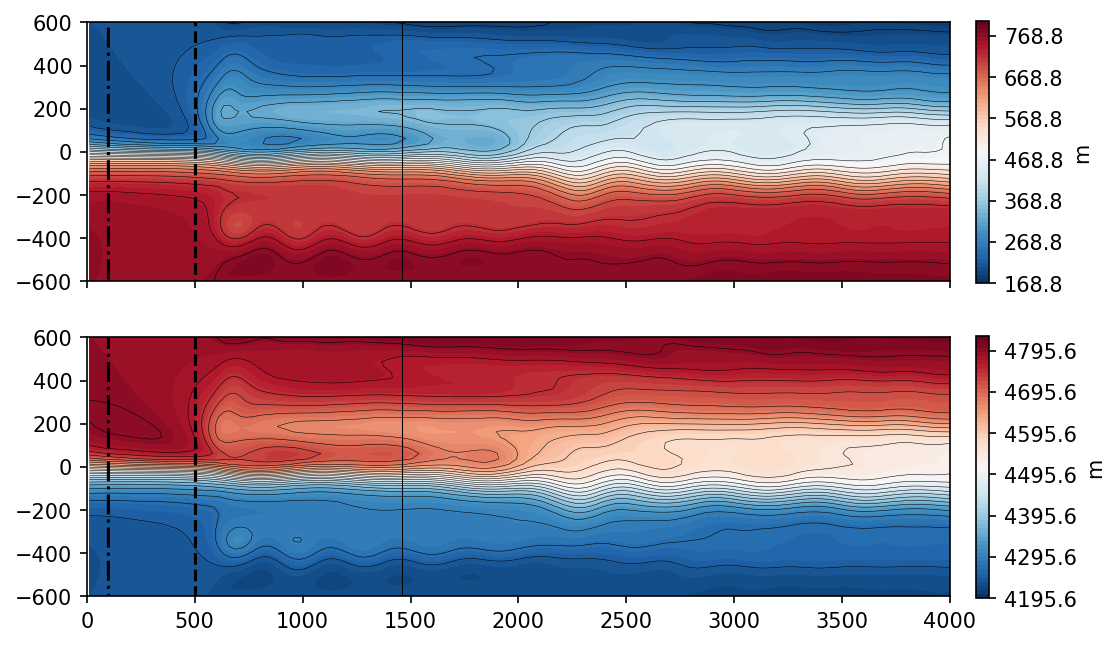

In [103]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmin = float(hbar.isel(zl=0, yh=-1).mean().values) - 40
vmax = float(hbar.isel(zl=0, yh= 1).mean().values) + 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmax = float(hbar.isel(zl=1, yh=-1).mean().values) + 40
vmin = float(hbar.isel(zl=1, yh= 1).mean().values) - 40
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

fig.savefig(os.path.join(expdir,'h_zoom.pdf'), bbox_inches='tight')

## Pressure

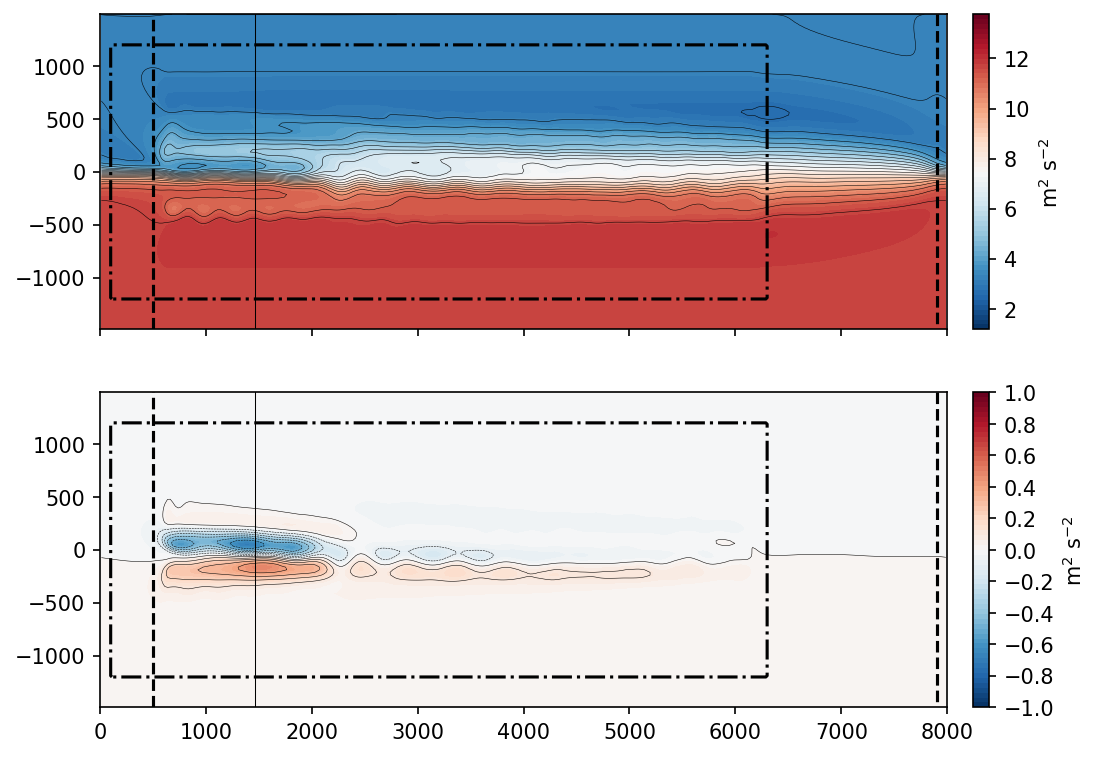

In [101]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]

fld = g*ηbar.isel(zi=0)
vmin = float(fld.isel(yh=-1).mean().values) - 2
vmax = float(fld.isel(yh= 1).mean().values) + 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(2, 15, 2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = g*ηbar.isel(zi=0) + grid.gprime[1]*ηbar.isel(zi=1)
vmin = -1
vmax = 1
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, .2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+.1, .1), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'pressure.pdf'), bbox_inches='tight')

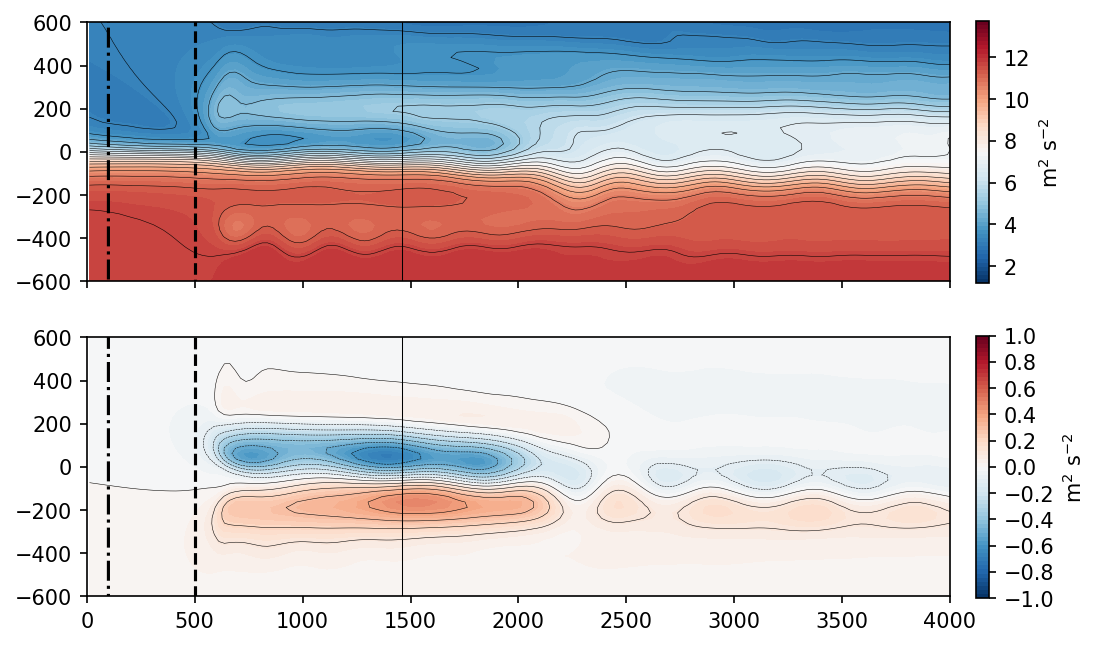

In [104]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]

fld = g*ηbar.isel(zi=0)
vmin = float(fld.isel(yh=-1).mean().values) - 2
vmax = float(fld.isel(yh= 1).mean().values) + 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(2, 15, 2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = g*ηbar.isel(zi=0) + grid.gprime[1]*ηbar.isel(zi=1)
vmin = -1
vmax = 1
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, .2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+.1, .1), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

fig.savefig(os.path.join(expdir,'pressure_zoom.pdf'), bbox_inches='tight')

## TWA vorticity

In [105]:
uh = prog.uh.isel(time=time_mean).mean('time').load()
vh = prog.vh.isel(time=time_mean).mean('time').load()
hbar = prog.h.isel(time=time_mean).mean('time').load()

In [106]:
hu = grid_op.interp(hbar, 'X')
hv = grid_op.interp(hbar, 'Y')
hq = grid_op.interp(hv, 'X')

uhat = uh/hu/grid.dyCu
vhat = vh/hv/grid.dxCv

zeta = (grid_op.diff(vhat*grid.dyCv, 'X') - grid_op.diff(uhat*grid.dxCu, 'Y'))/grid.area_q
Pi = (zeta + grid.fq)/hq

In [107]:
fld = 1e9*Pi.isel(zl=1)

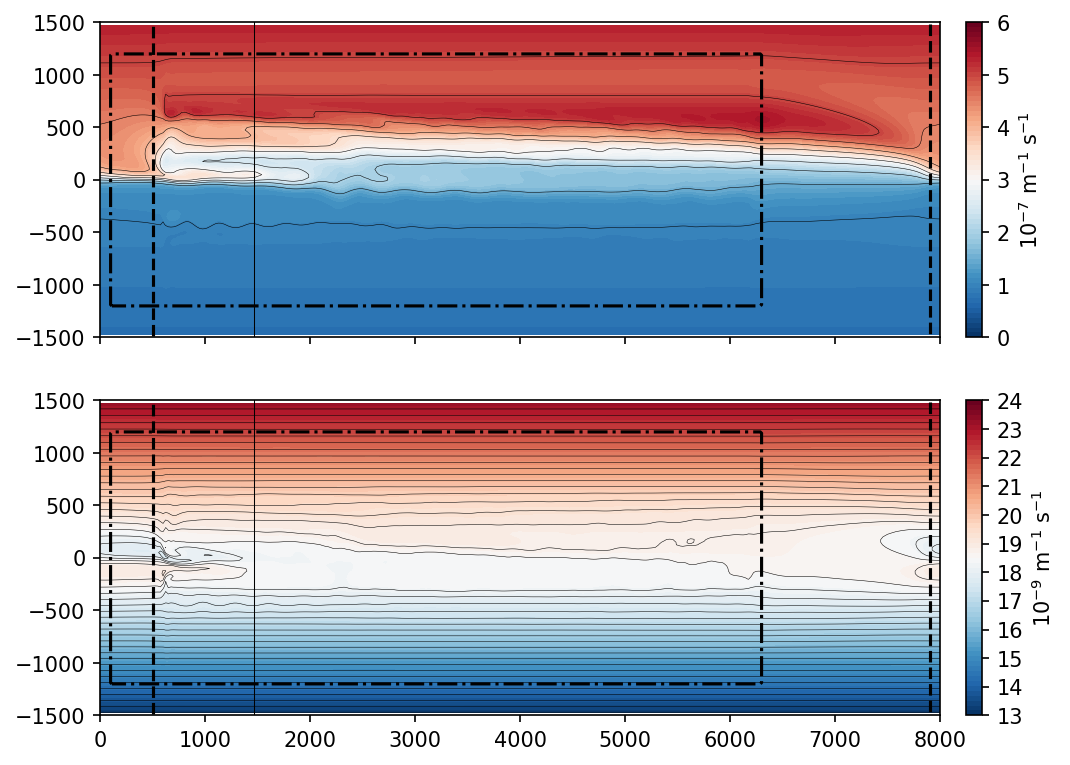

In [108]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmax = 70

fld = 1e7*Pi.isel(zl=0)

vmin = 0
vmax = 6
levels = np.linspace(vmin, vmax, 65)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmin = 13
vmax = 24
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'PV.pdf'), bbox_inches='tight')

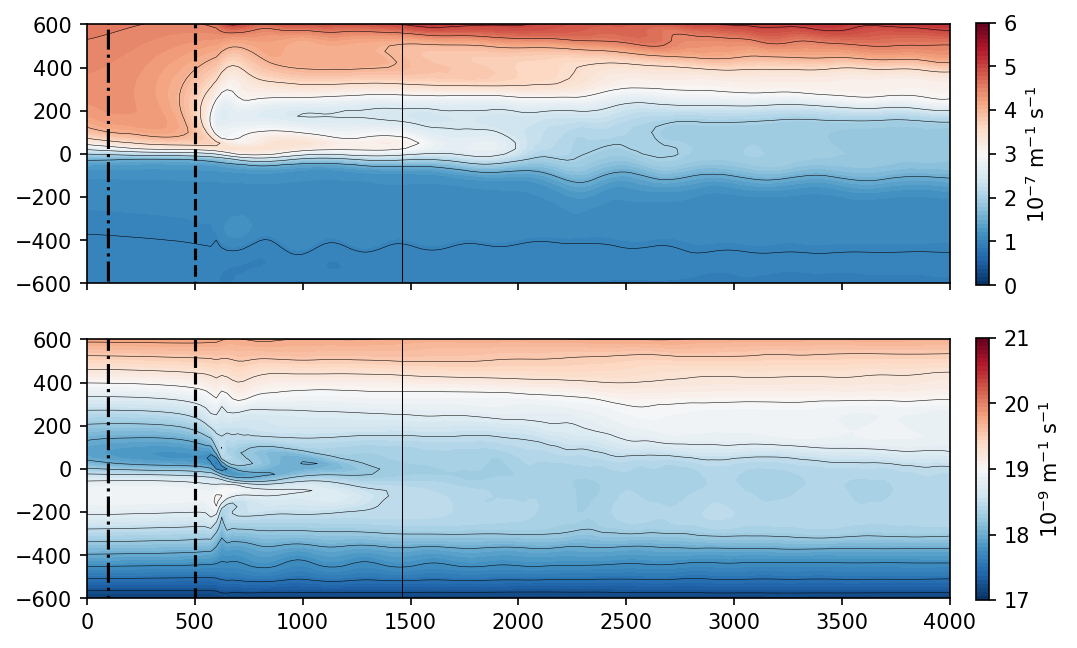

In [109]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmax = 70

fld = 1e7*Pi.isel(zl=0)

vmin = 0
vmax = 6
levels = np.linspace(vmin, vmax, 65)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmin = 17
vmax = 21
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'PV_zoom.pdf'), bbox_inches='tight')

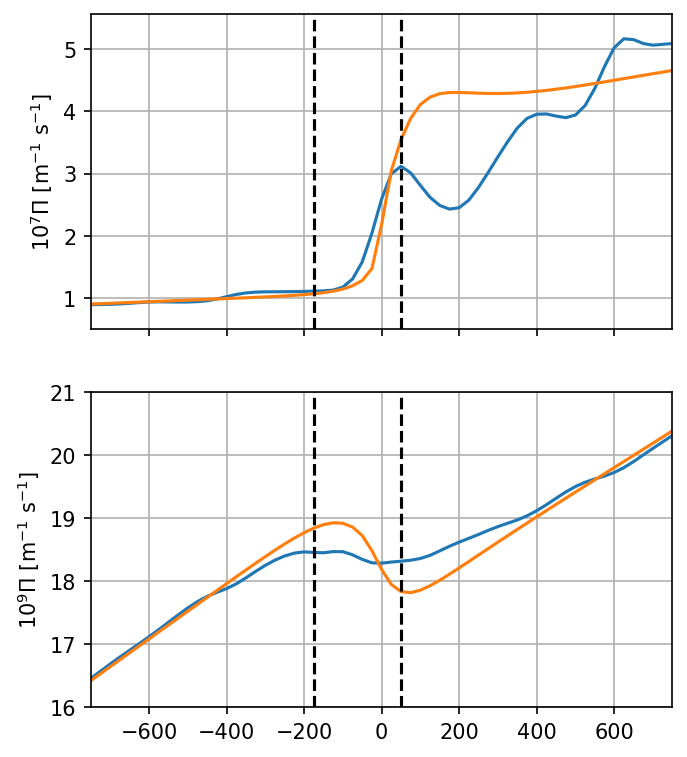

In [111]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

X = 250

ax = axs[0]
fld = 1e7*Pi.isel(zl=0)
ax.plot(fld.yq, fld.sel(xq=recirc_x, method='nearest'))
ax.plot(fld.yq, fld.sel(xq=X, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{7}\Pi$ [m$^{-1}$ s$^{-1}$]')

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)
ax.plot(fld.yq, fld.sel(xq=recirc_x, method='nearest'))
ax.plot(fld.yq, fld.sel(xq=X, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{9}\Pi$ [m$^{-1}$ s$^{-1}$]')
ax.set_ylim(16, 21)

ax.set_xlim([-750, 750])
fig.savefig(os.path.join(expdir,'PV_profile.pdf'), bbox_inches='tight')

# Close everything

In [60]:
prog.close()
grid.close()
stats.close()
ic.close()
real_ic.close()
mom.close()

try:
    client.close()
    cluster.close()
except:
    pass

In [4]:

client.close()
cluster.close()